# Assignment Details: 

Data source: https://www.kaggle.com/snap/amazon-fine-food-reviews 

#Reviews                   : 568,454 
#Users                     : 256,059 
#Products                  : 74,258 
 Time Span                 : Oct 1999 - Oct 2012
#Attributes/Columns in set : 10

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2). It is binary classification task. Ignore review rating  = 3.


In [25]:
# ==================================================== Import Libraries ========================================================

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
%matplotlib inline
import sqlite3 # for importing data from sqlite database
import nltk #for Natural Language Processing
from sklearn.feature_extraction.text import CountVectorizer #for bag of words
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer # for term frequency/inverse document frequency of words
 # Model Performance measures
import re # References for Regular Expressions: https://docs.python.org/3/howto/regex.html, https://regexr.com/2vhbb
import warnings
from nltk.corpus import stopwords
from wordcloud import WordCloud
from gensim.models import Word2Vec
warnings.simplefilter('ignore')
from tqdm import tqdm_notebook as tqdm
import itertools
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler #standarises the data
from scipy.sparse import csr_matrix #converts sparse to a dense matrix
from time import time
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors
from gensim.models import Word2Vec

In [26]:
# =================================================== Importing Data ===========================================================
conn = sqlite3.connect('./database.sqlite')
print(conn.execute('select * from Reviews').description) #prints colnames in the table
df = pd.read_sql_query('Select * from Reviews where Score !=3 LIMIT 3000',conn) #filtering neutral score = 3 from data

(('Id', None, None, None, None, None, None), ('ProductId', None, None, None, None, None, None), ('UserId', None, None, None, None, None, None), ('ProfileName', None, None, None, None, None, None), ('HelpfulnessNumerator', None, None, None, None, None, None), ('HelpfulnessDenominator', None, None, None, None, None, None), ('Score', None, None, None, None, None, None), ('Time', None, None, None, None, None, None), ('Summary', None, None, None, None, None, None), ('Text', None, None, None, None, None, None))


In [27]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [28]:
# ============================================ Exploratory Data Analysis =====================================================
print(df.shape)
df['Score'] = df['Score'].apply(lambda x: 'Positive' if x > 3 else 'Negative') # Target Variable preparation
print(df.columns.groupby(df.dtypes))

(3000, 10)
{dtype('int64'): Index(['Id', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'], dtype='object'), dtype('O'): Index(['ProductId', 'UserId', 'ProfileName', 'Score', 'Summary', 'Text'], dtype='object')}


In [29]:
sorted_data = df.sort_values(['UserId','Time'],ascending = True)
sorted_data.head(10)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2551,2779,B000J2DQ46,A10317LUD1C1VJ,CSN,8,9,Positive,1252713600,Bar Harbor All Natural New England Clam Chowde...,This is our preferred clam chowder . We like t...
1358,1474,B002BKTWL0,A103EZCS9H8WW1,Shirena Nicole Gonzalez,5,5,Positive,1272326400,Delicious,"These papers are great, they leave a delicious..."
2949,3212,B005K4Q1VI,A103U3KR4L2ZXT,"AndreaR ""andiemack""",0,0,Positive,1348185600,Great cup of cocoa,I like the rich dark smooth taste of the Grove...
155,171,B0064KO0BU,A104Y49ZQ4CYJ2,"H. Adams ""hollya""",0,0,Positive,1344816000,Worked great!,I purchased as a giveaway for a baby shower wi...
2047,2232,B002C4HZ00,A105FP1ZT88EPL,david lee,0,0,Positive,1329868800,CENTO SAN MARZANO,Purchased a small case of these tomatoes. I us...
1547,1676,B001RVFDOO,A107MO1RZUQ8V,Italian Girl,0,0,Positive,1291939200,Yum,That's all I can say. Yum at a great price! I ...
2226,2420,B0089SPDUW,A107SVKYGPGBPP,Angle Side Side,0,0,Positive,1335398400,Best K-Cup to Date,"If you're a fan of full-bodied coffees, give t..."
47,51,B001EO5QW8,A108P30XVUFKXY,Roberto A,0,7,Negative,1203379200,Don't like it,"This oatmeal is not good. Its mushy, soft, I d..."
1277,1380,B00068PCTU,A10CF04CJZC05F,"Suzanne ""Suzanne""",1,1,Positive,1248134400,Best tasting,This has been the best tasting Stevia I have t...
98,109,B001REEG6C,A10EHUTGNC4BGP,M. Foell,1,1,Positive,1243728000,Asparagus Bliss,"I love asparagus. Up until very recently, I h..."


There seems to be duplicate reviews given by same user at same time. These are due to MSKU (multi stock keeping units) products,
same product but are of different color/size, having different product ids as per Amazon catalogue. Say, there are 3 shirts 
of different colors (Red, Blue, Black) and all of them are sold by the same seller. In that case, Amazon lists them all in the 
same page under different product ids. Hence, a review comment on one of the shirt reflects the review comment in all the 
product ids. Hence, these are duplicated in the data. We need to remove such duplicates.

In [30]:
# de-duplication of data based on UserId,Time
dfinal = df.drop_duplicates(subset = {'UserId','ProfileName','Time'},keep='first',inplace = False)
dfinal.shape

(2964, 10)

In [31]:
#of duplicates in df
1-dfinal.size/df.size

0.01200000000000001

In [32]:
# Few other filters needed: #helpful comments cannot be more than the total comments
sum(dfinal.HelpfulnessNumerator > dfinal.HelpfulnessDenominator)

0

In [33]:
dfinal = dfinal[dfinal.HelpfulnessNumerator <= dfinal.HelpfulnessDenominator]

In [34]:
# Check for balance of classes
print(sum(dfinal['Score']=='Positive')/dfinal.shape[0])

0.8387314439946019


In [35]:
dfinal['Text'][1]

'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'

Text cannot be used as is, has to be converted into some numeric form (likes arrays or vectors of numbers) to be
used as feature in the model. But before that there is a need to process the text. 
1. Removing html tags (if any), since the urls does not add any information to the data.
2. Removing punctuations, non-alphanumeric characters. 
3. Need to lower/upper the cases so that 'Peanuts' & 'peanuts' are considered same.
4. Removing Stop words like which, what, whether, articles etc.
5. Removing text with <3 word length.
6. Stemming of words to its root/base word so that run, running, runs all considered to be same. 

In [36]:
# ===================================================Text Processing============================================================
## ==== UDFs====

def clean_html(text):
    tagsearch = re.compile('<.*?>')
    cleaned_txt = re.sub(tagsearch,' ',text)
    return(cleaned_txt)

def clean_pattern(text,pattern):
    cleaned_txt = re.sub(pattern,' ',text) #'[^a-zA-Z!]')
    #cleaned_txt = list(cleaned_txt)
    #cleaned_txt = [w.lower() for w in cleaned_txt.split() if len(w)>2]
    #cleaned_txt = ' '.join(cleaned_txt) 
    #print(cleaned_txt)
    return(cleaned_txt)

def exclamation_extract(x):
    em_words = []
    for i in x:
        em = re.findall(r"\w+!",i.lower())
        em_words.append(em)
    return em_words

sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer
stop = set(stopwords.words('english'))

In [37]:
## Removing html, non-alphanumeric, len(words)<3,
cleaned_sent = []
cleaned_sent_w2v = []
final_string = []
final_string_w2v = []
positive_wrds = []
negative_wrds = []
i = 0
s = ''
for sent in dfinal['Text'].values:
    str_list = []
    w2v_str_list = []
    sent = clean_html(sent) # removing html
    for w in clean_pattern(sent,'[^a-zA-Z]').split():
        if(len(w)>2):
            w2v_str_list.append(w.lower())
            s = sno.stem(w.lower())
            str_list.append(s)
            if ((dfinal['Score'].values[i]=='Positive') & (w.lower() not in stop)):
                positive_wrds.append(w.lower())
            if ((dfinal['Score'].values[i]=='Negative') & (w.lower() not in stop)): 
                negative_wrds.append(w.lower())
        else:
            continue
    cleaned_sent = " ".join(str_list)
    cleaned_sent_w2v = " ".join(w2v_str_list)
    final_string.append(cleaned_sent)
    final_string_w2v.append(cleaned_sent_w2v)
    i+=1

In [38]:
dfinal['cleaned_sent'] = final_string
dfinal['cleaned_sent_w2v'] = final_string_w2v
dfinal[-8:-7:]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,cleaned_sent,cleaned_sent_w2v
2992,3258,B005K4Q1VI,A31IMY00G32AD2,Hamer82,0,0,Negative,1335052800,Can taste artificial sweetner.,I was hoping this was a good idea. However we...,was hope this was good idea howev tri them eve...,was hoping this was good idea however tried th...


Since we have to get t-SNE plots, and since t-SNE requires dense matrix for plotting, we will work with 3000 data points only.
Also, since T-SNE is a distance based method, we need to standardise the dense matrix as well.

### t-SNE with Bag of Words Featurization 

In [15]:
## BOW: Bag of Words
count_vec = CountVectorizer(stop_words='english')
bow_words = count_vec.fit_transform(dfinal['cleaned_sent'].values)
print(bow_words.shape)
print("type of count vectorizer",type(bow_words))
print("="*50)
bow_words = csr_matrix.todense(bow_words)
print("type of count vectorizer",type(bow_words))
scaler = StandardScaler()
scaler.fit(bow_words)
bow_words = scaler.transform(bow_words)
print(bow_words)

(2964, 6740)
type of count vectorizer <class 'scipy.sparse.csr.csr_matrix'>
type of count vectorizer <class 'numpy.matrixlib.defmatrix.matrix'>
[[-0.01837106 -0.01837106 -0.01837106 ... -0.01837106 -0.03676073
  -0.01837106]
 [-0.01837106 -0.01837106 -0.01837106 ... -0.01837106 -0.03676073
  -0.01837106]
 [-0.01837106 -0.01837106 -0.01837106 ... -0.01837106 -0.03676073
  -0.01837106]
 ...
 [-0.01837106 -0.01837106 -0.01837106 ... -0.01837106 -0.03676073
  -0.01837106]
 [-0.01837106 -0.01837106 -0.01837106 ... -0.01837106 -0.03676073
  -0.01837106]
 [-0.01837106 -0.01837106 -0.01837106 ... -0.01837106 -0.03676073
  -0.01837106]]


time taken with perplexity = 3 is  1.6e+02 sec
time taken with perplexity = 10 is  1.6e+02 sec
time taken with perplexity = 20 is  1.8e+02 sec
time taken with perplexity = 30 is  1.9e+02 sec
time taken with perplexity = 50 is  2.4e+02 sec


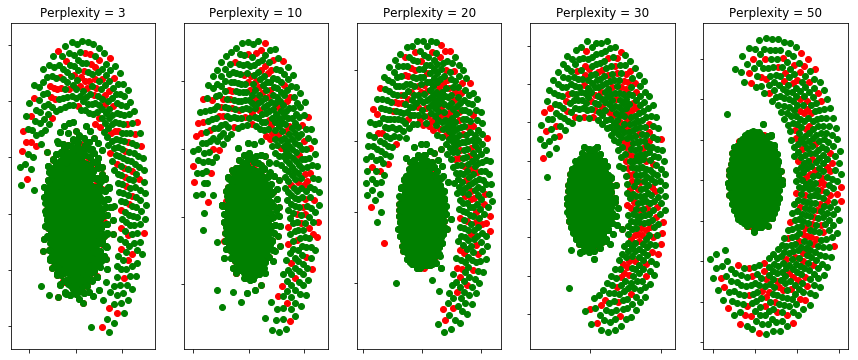

In [31]:
## https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py
n_dims = 2
random_state = 100
perplexities = [3,10,20,30,50]
(fig,subplots) = plt.subplots(1,5,figsize = (15,6))

red = dfinal['Score'] == 'Negative'
green = dfinal['Score'] == 'Positive'

for i, perplexity in enumerate(perplexities):
    ax = subplots[i]
    t0 = time()
    tsne = TSNE(n_components=n_dims,random_state=random_state,perplexity=perplexity)
    
    Y = tsne.fit_transform(bow_words)
    t1 = time()
    print("time taken with perplexity = %d is % .2g sec" % (perplexity, t1-t0))
    
    ax.set_title("Perplexity = %d" % perplexity)
    ax.scatter(Y[red,0],Y[red,1],c ="r")
    ax.scatter(Y[green,0],Y[green,1],c ="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    
plt.show()

 With perplexity = 3 it seems random/unstable. Perplexity = 30 seems to be quite stable with Bag of words featurization.

time taken with 1000 is  1.9e+02 sec
time taken with 2000 is  3e+02 sec
time taken with 3000 is  4.3e+02 sec


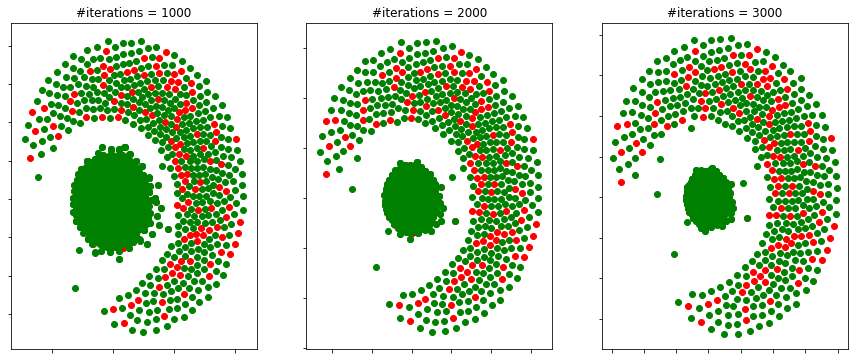

In [32]:
## https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py
n_dims = 2
random_state = 100
n_iters = [1000,2000,3000]
perplexity = 30
(fig,subplots) = plt.subplots(1,3,figsize = (15,6))

red = dfinal['Score'] == 'Negative'
green = dfinal['Score'] == 'Positive'

for i, n_iter in enumerate(n_iters):
    ax = subplots[i]
    t0 = time()
    tsne = TSNE(n_components = n_dims,random_state = random_state,perplexity = perplexity, n_iter = n_iter)
    
    Y = tsne.fit_transform(bow_words)
    t1 = time()
    print("time taken with %d is % .2g sec" % (n_iter, t1-t0))
    
    ax.set_title("#iterations = %d" % n_iter)
    ax.scatter(Y[red,0],Y[red,1],c ="r")
    ax.scatter(Y[green,0],Y[green,1],c ="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    
plt.show()

Perplexity of 30 and iterations of 2000 seem to be apt. Hence, getting a TSNE plot with tuned parameters.

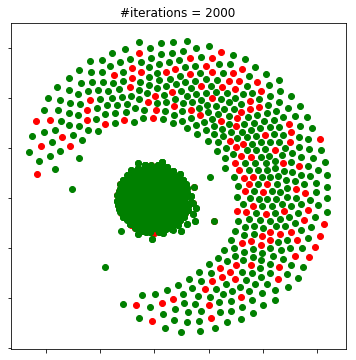

In [39]:
n_dims = 2
random_state = 100
n_iter = 2000
perplexity = 30
(fig,ax)= plt.subplots(1,1,figsize = (6,6))

red = dfinal['Score'] == 'Negative'
green = dfinal['Score'] == 'Positive'

tsne = TSNE(n_components = n_dims,random_state = random_state,perplexity = perplexity, n_iter = n_iter)
Y = tsne.fit_transform(bow_words)
ax.set_title("#iterations = %d" % n_iter)
ax.scatter(Y[red,0],Y[red,1],c ="r")
ax.scatter(Y[green,0],Y[green,1],c ="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

### t-SNE with TF-IDF Featurization

In [33]:
## TF-IDF: Term Frequency-Inverse Document Frequency
tfidf_vec = TfidfVectorizer(stop_words = 'english',ngram_range=(1,2), max_df= 500, min_df = 2)
tfidf_words = tfidf_vec.fit_transform(dfinal['cleaned_sent'])
print(tfidf_words.shape)
print("type of tfidf vectorizer",type(tfidf_words))
print("="*50)
tfidf_words = csr_matrix.todense(tfidf_words)
print("type of tfidf vectorizer",type(tfidf_words))
scaler = StandardScaler()
scaler.fit(tfidf_words)
tfidf_words = scaler.transform(tfidf_words)
print(tfidf_words.shape)

(2964, 14163)
type of tfidf vectorizer <class 'scipy.sparse.csr.csr_matrix'>
type of tfidf vectorizer <class 'numpy.matrixlib.defmatrix.matrix'>
(2964, 14163)


time taken with perplexity = 3 is  2.5e+02 sec
time taken with perplexity = 10 is  2.4e+02 sec
time taken with perplexity = 20 is  2.5e+02 sec
time taken with perplexity = 30 is  2.7e+02 sec
time taken with perplexity = 50 is  3.1e+02 sec


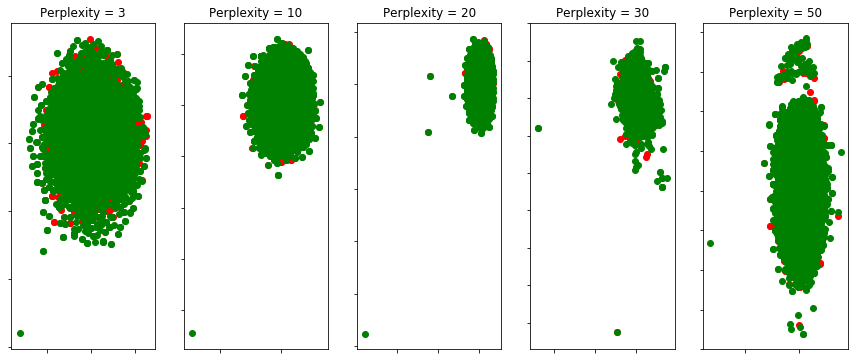

In [38]:
## https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py
n_dims = 2
random_state = 100
perplexities = [3,10,20,30,50]
(fig,subplots) = plt.subplots(1,5,figsize = (15,6))

red = dfinal['Score'] == 'Negative'
green = dfinal['Score'] == 'Positive'

for i, perplexity in enumerate(perplexities):
    ax = subplots[i]
    t0 = time()
    tsne = TSNE(n_components=n_dims,random_state=random_state,perplexity=perplexity)
    
    Y = tsne.fit_transform(tfidf_words)
    t1 = time()
    print("time taken with perplexity = %d is % .2g sec" % (perplexity, t1-t0))
    
    ax.set_title("Perplexity = %d" % perplexity)
    ax.scatter(Y[red,0],Y[red,1],c ="r")
    ax.scatter(Y[green,0],Y[green,1],c ="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    
plt.show()

Since, the data is highly imbalanced, we see less red points in the plots. So, we can take any perplexity value between 20-50. Let's take perplexity = 20 and proceed.

time taken with 1000 is  2.6e+02 sec
time taken with 2000 is  3.3e+02 sec
time taken with 3000 is  3.2e+02 sec


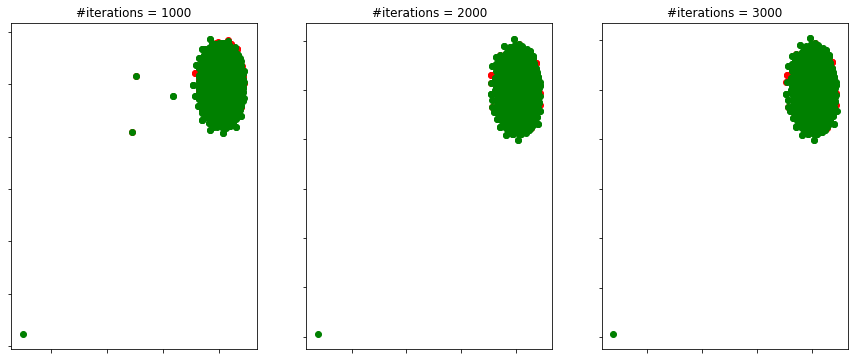

In [42]:
## https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py
n_dims = 2
random_state = 100
n_iters = [1000,2000,3000]
perplexity = 20
(fig,subplots) = plt.subplots(1,3,figsize = (15,6))

red = dfinal['Score'] == 'Negative'
green = dfinal['Score'] == 'Positive'

for i, n_iter in enumerate(n_iters):
    ax = subplots[i]
    t0 = time()
    tsne = TSNE(n_components = n_dims,random_state = random_state,perplexity = perplexity, n_iter = n_iter)
    
    Y = tsne.fit_transform(tfidf_words)
    t1 = time()
    print("time taken with %d is % .2g sec" % (n_iter, t1-t0))
    
    ax.set_title("#iterations = %d" % n_iter)
    ax.scatter(Y[red,0],Y[red,1],c ="r")
    ax.scatter(Y[green,0],Y[green,1],c ="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    
plt.show()

Running t-SNE with perplexity = 20 and iterations =  2000

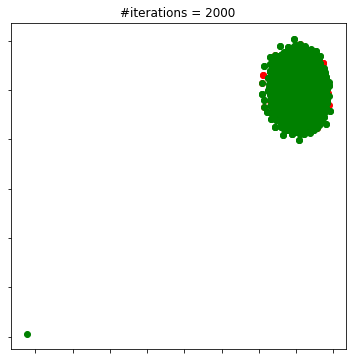

In [44]:
n_dims = 2
random_state = 100
n_iter = 2000
perplexity = 20
(fig,ax)= plt.subplots(1,1,figsize = (6,6))

red = dfinal['Score'] == 'Negative'
green = dfinal['Score'] == 'Positive'

tsne = TSNE(n_components = n_dims,random_state = random_state,perplexity = perplexity, n_iter = n_iter)
Y = tsne.fit_transform(tfidf_words)
ax.set_title("#iterations = %d" % n_iter)
ax.scatter(Y[red,0],Y[red,1],c ="r")
ax.scatter(Y[green,0],Y[green,1],c ="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

### Word2Vec Model

To build Word2Vec Model on Food Reviews data, we need lot of data points for it to find similarities. Hence, importing the pre-processed data that we saved earlier into final.sqlite database

In [4]:
conn = sqlite3.connect('final.sqlite')
data = pd.read_sql_query('Select * from Reviews',conn) 
data.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,em_words,cleaned_sent,cleaned_sent_w2v
0,0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,,have bought sever the vital can dog food produ...,have bought several the vitality canned dog fo...
1,1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,,product arriv label jumbo salt peanut the pean...,product arrived labeled jumbo salted peanuts t...
2,2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,,this confect that has been around few centuri ...,this confection that has been around few centu...
3,3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,,you are look for the secret ingredi robitussin...,you are looking for the secret ingredient robi...
4,4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...,,great taffi great price there was wide assort ...,great taffy great price there was wide assortm...


In [5]:
## Building Word2Vec model with food reviews data
list_of_sent = [text.split() for text in data['cleaned_sent_w2v']]
w2v_model = Word2Vec(list_of_sent)

In [6]:
w2v_model.wv['great']

array([ 2.5538316 ,  1.2545923 , -2.9592423 , -0.12318971,  1.7285835 ,
        3.0417705 , -2.1246336 ,  0.35431534, -0.91921663,  3.818395  ,
        1.9638393 ,  1.9131464 ,  1.1477841 ,  0.72143734,  0.89458686,
       -1.8621765 ,  5.1424847 , -0.44352162,  1.8453145 , -1.4635077 ,
        1.5374082 , -2.4648366 ,  0.46511045,  0.54770327,  0.59267557,
        1.9035931 , -0.39513263,  1.4207672 ,  2.0465353 ,  0.43973243,
        1.6593341 , -1.5188478 , -0.8772022 ,  1.1197912 , -1.8284712 ,
        0.44398573,  1.8183746 ,  2.926832  , -3.0041234 , -1.4880693 ,
        1.615394  ,  1.9651225 ,  0.5902965 , -0.40828642,  0.09212381,
       -1.5396652 , -2.1173415 ,  0.7148292 , -0.71789134,  2.000683  ,
       -1.9729781 , -4.9332666 ,  1.8704926 , -3.199673  ,  2.448789  ,
       -0.31208763, -0.3511248 , -0.39538348, -0.16523355,  2.2888596 ,
        0.18329361,  0.33710238, -0.26679754, -2.5751123 ,  0.05511647,
       -1.8330321 , -0.8446742 , -0.22735079,  2.809749  , -1.71

In [39]:
#Sampling the data
data = data.sample(n=3000,random_state=100)

### t-SNE with Average Word2Vec Features

In [40]:
## Avg W2V - Average Word2Vec based features
sent_vectors = []
count = 0
for text in tqdm(data['cleaned_sent_w2v'].values):
    counter = 0
    sent_vec = np.zeros(100)
    for word in text.split():
        try:
            word_vec = w2v_model.wv[word]
            sent_vec += word_vec
            counter +=1
        except:
            count +=1
            pass
    sent_vec /= counter
    sent_vectors.append(sent_vec)

HBox(children=(IntProgress(value=0, max=3000), HTML(value='')))

In [41]:
print("type of Average Word2Vec feature is:",type(sent_vectors))

type of Average Word2Vec feature is: <class 'list'>


time taken with perplexity = 3 is  42 sec
time taken with perplexity = 10 is  54 sec
time taken with perplexity = 20 is  68 sec
time taken with perplexity = 30 is  85 sec
time taken with perplexity = 50 is  1.1e+02 sec


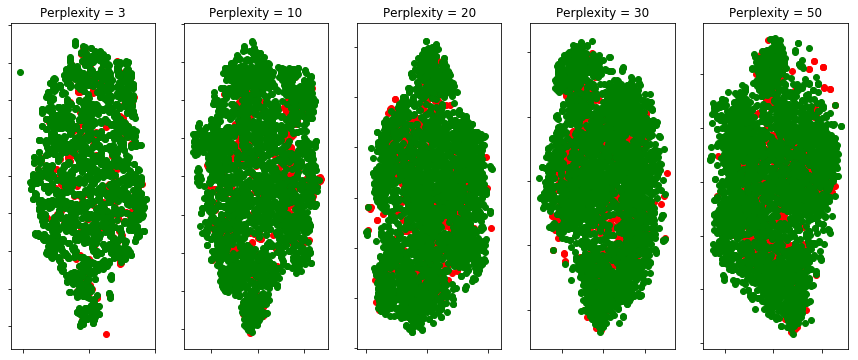

In [43]:
## https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py
n_dims = 2
random_state = 100
perplexities = [3,10,20,30,50]
(fig,subplots) = plt.subplots(1,5,figsize = (15,6))

red = data['Score'] == 'Negative'
green = data['Score'] == 'Positive'

for i, perplexity in enumerate(perplexities):
    ax = subplots[i]
    t0 = time()
    tsne = TSNE(n_components=n_dims,random_state=random_state,perplexity=perplexity)
    
    Y = tsne.fit_transform(sent_vectors)
    t1 = time()
    print("time taken with perplexity = %d is % .2g sec" % (perplexity, t1-t0))
    
    ax.set_title("Perplexity = %d" % perplexity)
    ax.scatter(Y[red,0],Y[red,1],c ="r")
    ax.scatter(Y[green,0],Y[green,1],c ="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    
plt.show()

time taken with 1000 is  86 sec
time taken with 2000 is  1.6e+02 sec
time taken with 3000 is  2.4e+02 sec


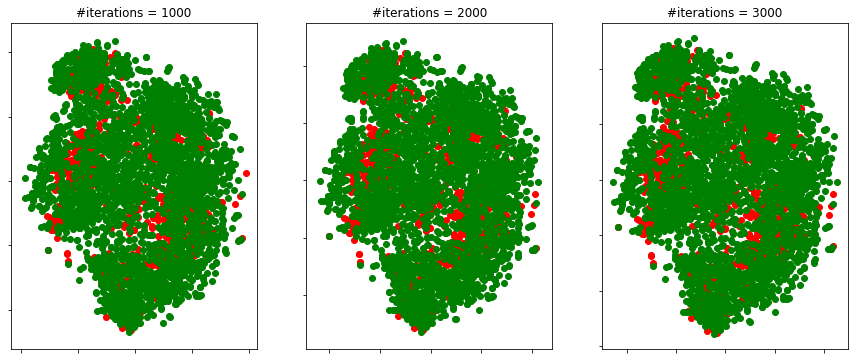

In [44]:
## https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py
n_dims = 2
random_state = 100
n_iters = [1000,2000,3000]
perplexity = 30
(fig,subplots) = plt.subplots(1,3,figsize = (15,6))

red = data['Score'] == 'Negative'
green = data['Score'] == 'Positive'

for i, n_iter in enumerate(n_iters):
    ax = subplots[i]
    t0 = time()
    tsne = TSNE(n_components = n_dims,random_state = random_state,perplexity = perplexity, n_iter = n_iter)
    
    Y = tsne.fit_transform(sent_vectors)
    t1 = time()
    print("time taken with %d is % .2g sec" % (n_iter, t1-t0))
    
    ax.set_title("#iterations = %d" % n_iter)
    ax.scatter(Y[red,0],Y[red,1],c ="r")
    ax.scatter(Y[green,0],Y[green,1],c ="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    
plt.show()

The dataset is so imblanaced, that both number of iterations and perplexity values doesnt make any difference.
Running t-SNE with perplexity = 30 and iterations = 2000

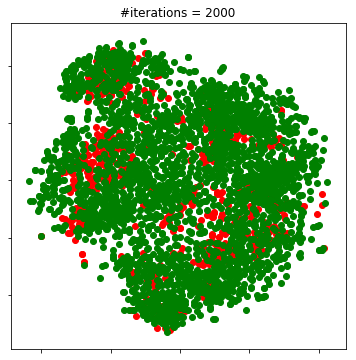

In [46]:
n_dims = 2
random_state = 100
n_iter = 2000
perplexity = 30
(fig,ax)= plt.subplots(1,1,figsize = (6,6))

red = data['Score'] == 'Negative'
green = data['Score'] == 'Positive'

tsne = TSNE(n_components = n_dims,random_state = random_state,perplexity = perplexity, n_iter = n_iter)
Y = tsne.fit_transform(sent_vectors)
ax.set_title("#iterations = %d" % n_iter)
ax.scatter(Y[red,0],Y[red,1],c ="r")
ax.scatter(Y[green,0],Y[green,1],c ="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

### t-SNE with TF-IDF Word2Vec Features

In [47]:
## TF-IDF W2V - Weighed average of word2vec based on tf-idf (weight) of the word
tfidfvec = TfidfVectorizer()
# give a matrix of all words, each cell represented by word has the tf-idf value
tfidfwords = tfidfvec.fit_transform(data['cleaned_sent_w2v']) 
dictionary = dict(zip(tfidfvec.get_feature_names(),list(tfidfvec.idf_))) # dict mapping of feature name as key and idf as value

list_of_sent = []
for sent in data['cleaned_sent_w2v'].values:
    list_of_sent.append(sent.split())

i = 0 # text row_id
tfidf_sent_vectors = []
for text in tqdm(list_of_sent):
    counter = 0
    sent_vec = np.zeros(100)
    tfidf_sent =0
    for word in text:
        try:
            word_vec = w2v_model.wv[word]
            tfidf_word = dictionary[word]*(text.count(word)/len(text))  # idf*tf
            sent_vec += word_vec*tfidf_word
            tfidf_sent += tfidf_word
        except:
            pass
    sent_vec /= tfidf_sent 
    tfidf_sent_vectors.append(sent_vec)
    i+=1

HBox(children=(IntProgress(value=0, max=3000), HTML(value='')))

time taken with perplexity = 3 is  47 sec
time taken with perplexity = 10 is  54 sec
time taken with perplexity = 20 is  72 sec
time taken with perplexity = 30 is  84 sec
time taken with perplexity = 50 is  1.2e+02 sec


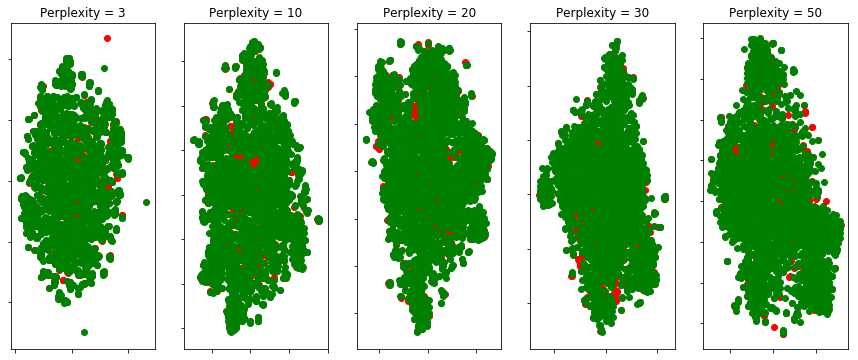

In [48]:
## https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py
n_dims = 2
random_state = 100
perplexities = [3,10,20,30,50]
(fig,subplots) = plt.subplots(1,5,figsize = (15,6))

red = data['Score'] == 'Negative'
green = data['Score'] == 'Positive'

for i, perplexity in enumerate(perplexities):
    ax = subplots[i]
    t0 = time()
    tsne = TSNE(n_components=n_dims,random_state=random_state,perplexity=perplexity)
    
    Y = tsne.fit_transform(tfidf_sent_vectors)
    t1 = time()
    print("time taken with perplexity = %d is % .2g sec" % (perplexity, t1-t0))
    
    ax.set_title("Perplexity = %d" % perplexity)
    ax.scatter(Y[red,0],Y[red,1],c ="r")
    ax.scatter(Y[green,0],Y[green,1],c ="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    
plt.show()

time taken with 1000 is  86 sec
time taken with 2000 is  1.7e+02 sec
time taken with 3000 is  2.5e+02 sec


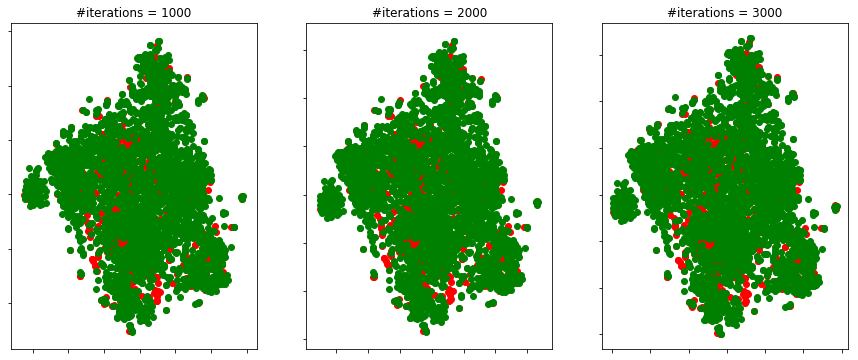

In [49]:
## https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html#sphx-glr-auto-examples-manifold-plot-t-sne-perplexity-py
n_dims = 2
random_state = 100
n_iters = [1000,2000,3000]
perplexity = 30
(fig,subplots) = plt.subplots(1,3,figsize = (15,6))

red = data['Score'] == 'Negative'
green = data['Score'] == 'Positive'

for i, n_iter in enumerate(n_iters):
    ax = subplots[i]
    t0 = time()
    tsne = TSNE(n_components = n_dims,random_state = random_state,perplexity = perplexity, n_iter = n_iter)
    
    Y = tsne.fit_transform(tfidf_sent_vectors)
    t1 = time()
    print("time taken with %d is % .2g sec" % (n_iter, t1-t0))
    
    ax.set_title("#iterations = %d" % n_iter)
    ax.scatter(Y[red,0],Y[red,1],c ="r")
    ax.scatter(Y[green,0],Y[green,1],c ="g")
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')
    
plt.show()

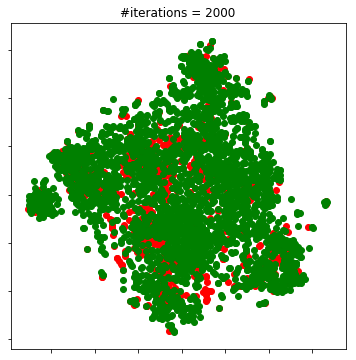

In [50]:
n_dims = 2
random_state = 100
n_iter = 2000
perplexity = 30
(fig,ax)= plt.subplots(1,1,figsize = (6,6))

red = data['Score'] == 'Negative'
green = data['Score'] == 'Positive'

tsne = TSNE(n_components = n_dims,random_state = random_state,perplexity = perplexity, n_iter = n_iter)
Y = tsne.fit_transform(tfidf_sent_vectors)
ax.set_title("#iterations = %d" % n_iter)
ax.scatter(Y[red,0],Y[red,1],c ="r")
ax.scatter(Y[green,0],Y[green,1],c ="g")
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

## Conclusion:

PCA is a linear algorithm (co-variance based; linear combination of features), preserves the global shape of the data while t-SNE preserves the local/neighborhood shape of the data. t-SNE is a non-linear dimensionality reduction technique majorly used for visualization.
t-SNE identifies the cluster of points near to each other in d-dimensional space and preserves the neighborhood distances between the points while embedding into 2 dimensional space and doesn’t care to preserved the distance of the farther points in 2 dimensional space.